<center>
<img src="https://habrastorage.org/webt/ia/m9/zk/iam9zkyzqebnf_okxipihkgjwnw.jpeg" />
    
## [mlcourse.ai](https://mlcourse.ai) - Open Machine Learning Course

Автор: [Yury Kashnitsky](https://yorko.github.io). Все материалы распространяются под [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/).

# Задание #5
## Слуйчаный Лес (Random Forest) и Логистическая Регрессия (Logistic Regression) в кредитном скоринге и классификации кинорецензий
 
В этой части мы рассмотрим плюсы и минусы этих двух алгоритмов в двух разных задачах.

### Задача состоит в том, чтобы:
 1. написать код и выполнить вычисления в ячейках ниже;
 2. выбрать ответы в [веб-форме](https://forms.gle/VvfLZiXfssf4aTBv7).
    

*Если вы уверены, что в задании/решении что-то не на 100% верно, пожалуйста, оставьте свой отзыв через указанную веб-форму ↑*.

-----

**1. В зале суда находятся 9 присяжных заседателей. Каждый из них в отдельности может правильно определить, виновен подсудимый или нет, с вероятностью 75%. Какова вероятность того, что присяжные совместно вынесут правильный вердикт, если окончательное решение будет принято большинством голосов?**

- 60.97%
- 80.00%
- 95.11%
- 96.66%

Ответ: 95.11%

$ \large N = 9, m = 5, p = 0.75, q = 1 - p = 0.25 $
$$ \large P = \sum_ {i = m} ^ N C_ N ^ i p ^ i q ^ {N - i} =
   \sum_ {i = 5} ^ 9 C_ 9 ^ i \cdot 0.75 ^ i \cdot 0.25 ^ {9 - i} = 0.9511 $$

In [1]:
from IPython.display import Math
from math import factorial as f

def C(n, k): return f(n) / (f(k) * f(n - k))

N = 9
m = 5
p = .75
q = 1. - p
P = 0. # answer

for i in range(m, N + 1):
    P += C(N, i) * p**i * q**(N - i)

display(Math(f"{P*100:.2f}\%"))

Теперь перейдем непосредственно к машинному обучению.

**Задача**

Предсказать, погасит ли клиент кредит в течение 90 дней. Это задача бинарной классификации; на основе нашего прогноза мы будем распределять клиентов по категориям "_хорошие_" и "_плохие_".

**Описание данных**

| Признак                              | Тип признака    | Тип значения        | Описание                                                                                                          |
|--------------------------------------|-----------------|---------------------|-------------------------------------------------------------------------------------------------------------------|
| age                                  | Входной признак | integer             | Возраст клиента                                                                                                   |
| DebtRatio                            | Входной признак | real                | Общая сумма ежемесячных платежей по кредиту (займу, алиментам и т.д.) / Общий процент ежемесячного дохода         |
| NumberOfTime30-59DaysPastDueNotWorse | Входной признак | integer             | Количество случаев, когда клиент имел просрочку 30-59 дней (не хуже) по другим кредитам в течение последних 2 лет |
| NumberOfTimes90DaysLate              | Входной признак | integer             | Количество случаев, когда клиент имел просрочку по другим кредитам на 90+ дней                                    |
| NumberOfTime60-89DaysPastDueNotWorse | Входной признак | integer             | Количество случаев, когда клиент имел 60-89dpd (не хуже) за последние 2 года                                      |
| NumberOfDependents                   | Входной признак | integer             | Количество иждивенцев клиента                                                                                     |
| SeriousDlqin2yrs                     | Target Variable | binary:<br>(0 or 1) | Клиент не погасил задолженность по кредиту в течение 90 дней                                                      |

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# sharper plots
%config InlineBackend.figure_format = 'retina'

Реализуем функцию, которая будет заменять значения NaN на медиану в каждом столбце таблицы.

In [3]:
def impute_nan_with_median(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table

Further, we read the data into a dataframe. No need to download anything, the requisite file `data/credit_scoring_sample.csv.zip` is not large and it goes with the archive with bonus assignments.

In [4]:
data = pd.read_csv("../data/credit_scoring_sample.csv.zip", sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


Просмотр типов данных признаков:

In [5]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Посмотрим на распределение целевой переменной:

Distribution of target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

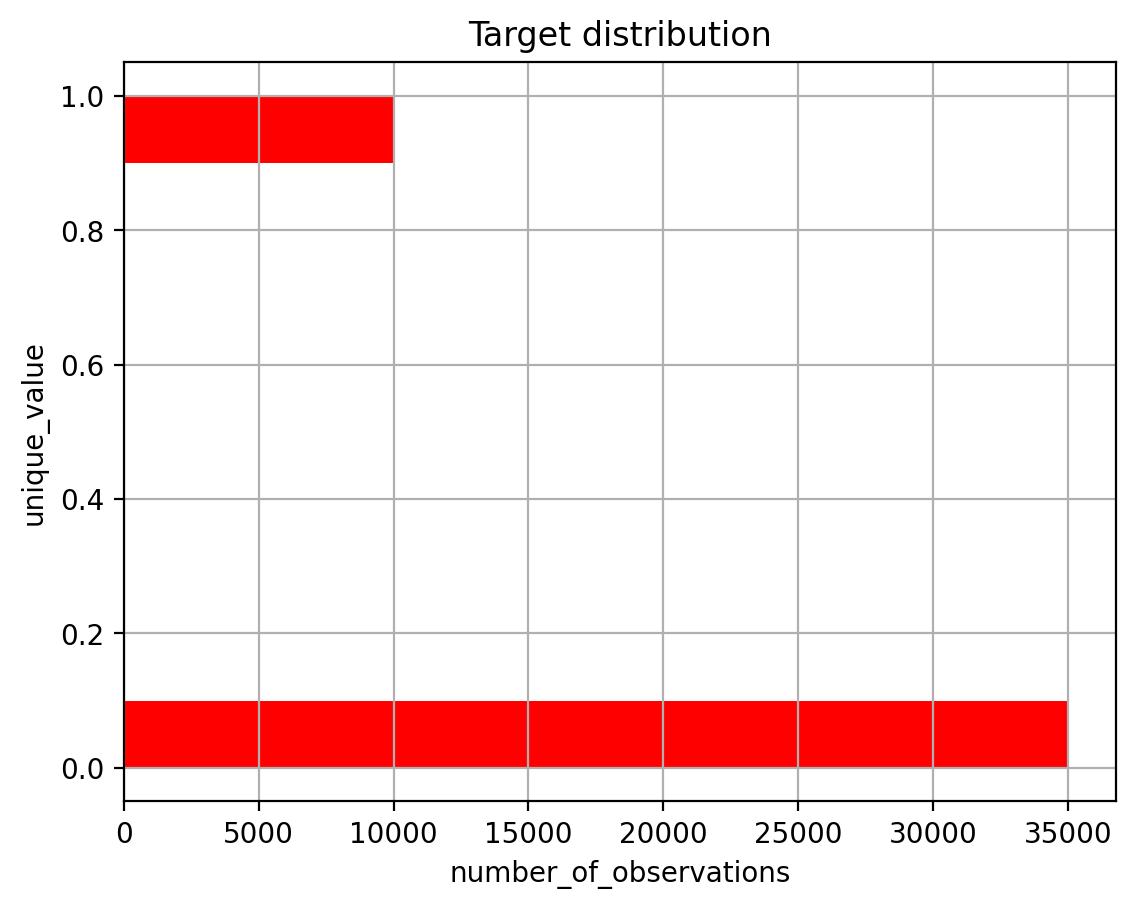

In [6]:
ax = data["SeriousDlqin2yrs"].hist(orientation="horizontal", color="red")
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print("Distribution of target:")
data["SeriousDlqin2yrs"].value_counts(normalize=True)

Выделяем все признаки и отбрасываем цель:

In [7]:
independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != "SeriousDlqin2yrs"]
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

Мы применяем функцию, которая заменяет все значения NaN на медианное значение соответствующего признака.

In [8]:
table = impute_nan_with_median(data)

Разделим цель и признаки - теперь мы получим обучающее множество.

In [9]:
X = table[independent_columns_names]
y = table["SeriousDlqin2yrs"]

### Bootstrap

**2. Построить интервальную оценку на основе bootstrap (2000 выборок) среднего дохода (MonthlyIncome) клиентов, имевших просроченные платежи по кредиту, и тех, кто платил вовремя, составить 80% доверительный интервал. Для разбиения данных используйте целевое значение (SeriousDlqin2yrs). Найдите разницу между нижней границей полученного интервала для тех, кто платил вовремя, и верхней границей для тех, кто просрочил платежи.
Итак, предлагается построить 80%-ные интервалы для доходов "хороших" клиентов `[good_income_lower, good_income_upper]` и "плохих" - [`bad_income_lower`, `bad_income_upper`] и найти разность `good_income_upper - bad_income_lower`.**

Установите `np.random.seed(17)`. Округлите ответ до ближайшего целого числа. [Статья](https://mlcourse.ai/book/topic05/topic5_part1_bagging.html#bootstrapping)

- 654
- 714
- 834 
- 996

Ответ: 996

In [10]:
def get_bootstrap_samples(data, n_samples, seed=17):
    """Generate bootstrap samples using the bootstrap method."""
    np.random.seed(seed)
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples


def stat_intervals(stat, alpha):
    """Produce an interval estimate."""
    boundaries = np.percentile(stat, [100 * alpha / 2.0, 100 * (1 - alpha / 2.0)])
    return boundaries


# Save data about overdues
churn = data[data["SeriousDlqin2yrs"] == 1]["MonthlyIncome"].values
not_churn = data[data["SeriousDlqin2yrs"] == 0]["MonthlyIncome"].values


# Generate bootstrap samples and calculate the means
churn_mean_scores = [
    np.mean(sample) for sample in get_bootstrap_samples(churn, 2000)
]
not_churn_mean_scores = [
    np.mean(sample) for sample in get_bootstrap_samples(not_churn, 2000)
]

print(f"Bad customers mean interval {stat_intervals(churn_mean_scores, 0.2)}")
print(f"Good customers mean interval {stat_intervals(not_churn_mean_scores, 0.2)}")
print(
    "Difference is",
    stat_intervals(not_churn_mean_scores, 0.2)[1]
    - stat_intervals(churn_mean_scores, 0.2)[0],
)

Bad customers mean interval [5482.66379414 5625.22886495]
Good customers mean interval [6310.92322402 6478.45869224]
Difference is 995.7948981043837


### Дерево решений, настройка гиперпараметров

Одной из основных метрик эффективности модели является площадь под ROC-кривой. Значения ROC-AUC лежат в диапазоне от 0 до 1. Чем ближе значение ROC-AUC к 1, тем лучше выполнена классификация.

Найдем значения гиперпараметров `DecisionTreeClassifier` с помощью `GridSearchCV`, которые максимизируют площадь под ROC-кривой.

In [11]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

Для создания дерева решений используется класс `DecisionTreeClassifier`. В связи с несбалансированностью классов в цели мы добавляем параметр балансировки. Для воспроизводимости результатов мы также используем параметр `random_state = 17`.

In [12]:
dt = DecisionTreeClassifier(random_state=17, class_weight="balanced")

Мы рассмотрим такие значения гиперпараметров:

In [13]:
max_depth_values = [5, 6, 7, 8, 9]
max_features_values = [4, 5, 6, 7]
tree_params = {"max_depth": max_depth_values, "max_features": max_features_values}

Установить параметры кросс-валидации: stratified, 5 partitions with shuffle, 
`random_state`. Это разбиение мы будем использовать во всем блокноте.

In [14]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

**3. Запустите GridSearch с метрикой ROC AUC, используя гиперпараметры из словаря `tree_params`. Каково максимальное значение ROC AUC (округлите до 2 знаков после запятой)? Мы называем кросс-валидацию стабильной, если стандартное отклонение метрики на кросс-валидации меньше 0.01. Является ли кросс-валидация устойчивой при оптимальных комбинациях гиперпараметров (т.е. обеспечивающих максимум среднего значения ROC AUC для кросс-валидации).**

- 0.82, нет
- 0.84, нет
- 0.82, да
- 0.84, да

Ответ: 0.82, да

In [15]:
dt_grid = GridSearchCV(dt, tree_params, scoring="roc_auc", cv=skf, n_jobs=-1)

In [16]:
%%time

dt_grid.fit(X, y)

CPU times: user 259 ms, sys: 144 ms, total: 402 ms
Wall time: 1.96 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7, 8, 9],
                         'max_features': [4, 5, 6, 7]},
             scoring='roc_auc')

In [17]:
print(f"{dt_grid.best_score_:.2f}\n{dt_grid.best_params_ = }")

std = dt_grid.cv_results_["std_test_score"][
    np.argmax(dt_grid.cv_results_["mean_test_score"])
]
print(f"{std}\n{std < .01}")

0.82
dt_grid.best_params_ = {'max_depth': 7, 'max_features': 6}
0.0038920985350028546
True


### Простая реализация RandomForest

**4. Реализуйте собственный случайный лес с помощью `DecisionTreeClassifier` с оптимальными параметрами из предыдущей задачи. Будет создано 10 деревьев, предсказанные вероятности которых необходимо усреднить.**

Краткая спецификация:
 - Используйте приведенный ниже базовый код
 - В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
   * фиксируем seed равным (`random_state + i`). Идея заключается в том, что на каждой итерации задается новое значение случайного семени, чтобы добавить больше "случайности", но в то же время результаты воспроизводимы
   * После фиксации seed выбираем `max_features` признаков **без замены**, сохраняем список идентификаторов выбранных признаков в `self.feat_ids_by_tree`.
   * Также сделайте бутстреп-выборку (т.е. **выборку с заменой**) обучающих экземпляров. Для этого воспользуйтесь функцией `np.random.choice` и ее аргументом `replace`.
   * Обучение дерева решений с заданными (в конструкторе) аргументами `max_depth`, `max_features` и `random_state` (не указывать `class_weight`) на соответствующем подмножестве обучающих данных. 
 - Метод `fit` возвращает текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self`.
 - В методе `predict_proba` нам необходимо пройтись по всем деревьям. Для каждого предсказания, очевидно, нужно брать только те признаки, которые мы использовали при обучении соответствующего дерева. Метод возвращает предсказанные вероятности (`predict_proba`), усредненные по всем деревьям

Выполните кросс-валидацию с помощью `StratifiedKFold`. Каково среднее значение ROC AUC кросс-валидации для собственной реализации Random Forest? Выберите наиболее близкое значение.

- 0.823
- 0.833
- 0.843
- 0.853

Ответ: 0.833

In [18]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score


class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=10, max_features=10, random_state=17
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.features_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)
            features_to_use_ids = np.random.choice(
                range(X.shape[1]), min(self.max_features, X.shape[1]), replace=False
            )
            examples_to_use = list(
                set(np.random.choice(range(X.shape[0]), X.shape[0], replace=True))
            )
            self.features_ids_by_tree.append(features_to_use_ids)
            
            dt = DecisionTreeClassifier(
                max_depth=self.max_depth,
                max_features=self.max_features,
                random_state=self.random_state
            )

            dt.fit(X[examples_to_use, :][:, features_to_use_ids], y[examples_to_use])
            self.trees.append(dt)
        
        return self


    def predict_proba(self, X):
        predictions = []
        for i in range(self.n_estimators):
            features_to_use_ids = self.features_ids_by_tree[i]
            predictions.append(self.trees[i].predict_proba(X[:, features_to_use_ids]))
        return np.mean(predictions, axis=0)

In [19]:
%%time

cv_aucs = cross_val_score(
    RandomForestClassifierCustom(max_depth=7, max_features=6),
    X.values,
    y.values,
    scoring="roc_auc",
    cv=skf
)

print(f"Mean ROC AUC: {np.mean(cv_aucs)}")

Mean ROC AUC: 0.8324389040118156
CPU times: user 1.69 s, sys: 0 ns, total: 1.69 s
Wall time: 1.69 s


**5. Сравним собственную реализацию случайного леса с его версией в `sklearn`. Для этого используем `RandomForestClassifier (class_weight='balanced', n_estimators=10, random_state=17)`, задаем все те же значения для `max_depth` и `max_features`, что и ранее. Какое среднее значение ROC AUC при кросс-валидации мы получили в итоге? Выберите наиболее близкое значение.**

- 0.814
- 0.827
- 0.843
- 0.856

Ответ: 0.827

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
%%time

cv_aucs = cross_val_score(
    RandomForestClassifier(
        n_estimators=10,
        max_depth=7,
        max_features=6,
        class_weight="balanced",
        n_jobs=-1,
        random_state=17,
    ),
    X.values,
    y.values,
    scoring="roc_auc",
    cv=skf
)

print(f"Mean ROC AUC: {np.mean(cv_aucs)}")

Mean ROC AUC: 0.8294245044403752
CPU times: user 147 ms, sys: 32.3 ms, total: 180 ms
Wall time: 375 ms


### `sklearn` RandomForest, настройка гиперпараметров

**6. В третьей задаче мы нашли оптимальные гиперпараметры для одного дерева. Однако может оказаться, что для ансамбля эти параметры не оптимальны. Проверим это предположение с помощью `GridSearchCV` `(RandomForestClassifier (class_weight='balanced', n_estimators=10, random_state=17)` ). Теперь мы увеличиваем значение `max_depth` до 15, поскольку деревья должны находиться глубже в лесу. Каковы теперь оптимальные значения гиперпараметров?**

- `max_depth=8, max_features=4`
- `max_depth=9, max_features=5`
- `max_depth=10, max_features=6`
- `max_depth=11, max_features=7`

Ответ: `max_depth=8, max_features=4`

In [22]:
max_depth_values = range(5, 15)
max_features_values = [4, 5, 6, 7]
forest_params = {"max_depth": max_depth_values, "max_features": max_features_values}

In [23]:
%%time

rf = RandomForestClassifier(n_estimators=10, class_weight="balanced", n_jobs=-1, random_state=17)
rf_grid = GridSearchCV(rf, forest_params, scoring="roc_auc", cv=skf, n_jobs=-1)
rf_grid.fit(X.values, y.values)

CPU times: user 800 ms, sys: 39 ms, total: 839 ms
Wall time: 10.2 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_estimators=10, n_jobs=-1,
                                              random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': range(5, 15),
                         'max_features': [4, 5, 6, 7]},
             scoring='roc_auc')

In [24]:
rf_grid.best_score_

0.8309382382771451

In [25]:
rf_grid.best_params_

{'max_depth': 8, 'max_features': 5}

In [26]:
rf_grid.cv_results_["std_test_score"][np.argmax(rf_grid.cv_results_["mean_test_score"])]

0.002850452942332219

### Logistic regression, настройка гиперпараметров

**7. Теперь сравним наши результаты с логистической регрессией (указываем `class_weight = 'balanced'`, `solver='liblinear'` и `random_state=17`). Выполним полный перебор по параметру `C` из широкого диапазона значений `np.logspace (-8, 8, 17)`. Теперь построим пайплайн - сначала применим скейлинг, затем обучим модель.**

Каково наилучшее среднее значение ROC AUC? Выберите наиболее близкое значение.

- 0.788
- 0.798
- 0.808
- 0.818

Ответ: 0.788

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
logit = LogisticRegression(
    random_state=17, solver="liblinear", class_weight="balanced"
)

logit_pipe = Pipeline([("scaler", scaler), ("logit", logit)])
logit_pipe_params = {"logit__C": np.logspace(-8, 8, 17)}

In [28]:
%%time

logit_pipe_grid = GridSearchCV(logit_pipe, logit_pipe_params, scoring="roc_auc", cv=skf, n_jobs=-1)
logit_pipe_grid.fit(X.values, y.values)

CPU times: user 234 ms, sys: 43.2 ms, total: 277 ms
Wall time: 1.85 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logit',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=17,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logit__C': array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08])},
             scoring='roc_auc')

In [29]:
logit_pipe_grid.best_score_

0.7880668344494914

In [30]:
logit_pipe_grid.best_params_

{'logit__C': 10000.0}

In [31]:
logit_pipe_grid.cv_results_["std_test_score"][np.argmax(logit_pipe_grid.cv_results_["mean_test_score"])]

0.0047244925974075985

### Logistic regression и RandomForest на разреженных признаках

В случае небольшого количества признаков случайный лес оказался лучше логистической регрессии. Однако одним из основных недостатков деревьев является их работа с разреженными данными, например, с текстами. Давайте сравним логистическую регрессию и случайный лес в новой задаче.
Загрузим набор данных с рецензиями на фильмы с сайта [здесь](https://drive.google.com/file/d/12OPgwkx5Q63iqxXGR3MqZQpiMev_aB7g/view?usp=sharing).

In [32]:
import os
import gdown

if not os.path.exists("../data/movie_reviews_train.csv.zip"):
    gdown.download(id="12OPgwkx5Q63iqxXGR3MqZQpiMev_aB7g", output="../data/movie_reviews_train.csv.zip")

Downloading...
From (uriginal): https://drive.google.com/uc?id=12OPgwkx5Q63iqxXGR3MqZQpiMev_aB7g
From (redirected): https://drive.google.com/uc?id=12OPgwkx5Q63iqxXGR3MqZQpiMev_aB7g&confirm=t&uuid=dd533cc7-1b4a-4e56-a8a3-cf4b61339c92
To: /home/m-melgizin/repos/mlcourse.ai-solution/data/movie_reviews_train.csv.zip
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30.2M/30.2M [00:06<00:00, 4.39MB/s]


In [33]:
# Download data
df = pd.read_csv("../data/movie_reviews_train.csv.zip", nrows=50000)

# Split data to train and test
X_text = df["text"]
y_text = df["label"]

# Classes counts
df.label.value_counts()

1    32492
0    17508
Name: label, dtype: int64

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# Split on 3 folds
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

# In Pipeline we will modify the text and train logistic regression
classifier = Pipeline(
    [
        ("vectorizer", CountVectorizer(max_features=100000, ngram_range=(1, 3))),
        ("clf", LogisticRegression(solver="liblinear", random_state=17)),
    ]
)

**8. Для Logistic Regression: перебрать параметр `C` со значениями из списка [0.1, 1, 10, 100] и найти наилучшее значение ROC AUC при кросс-валидации. Выберите наиболее близкий ответ.**

- 0.71
- 0.75
- 0.81
- 0.85

Ответ: 0.85

In [35]:
%%time

params = {"clf__C": (.1, 1, 10, 100)}
grid = GridSearchCV(classifier, params, scoring="roc_auc", cv=skf, n_jobs=-1)
grid.fit(X_text, y_text)

CPU times: user 12.3 s, sys: 19.2 s, total: 31.5 s
Wall time: 19.1 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(max_features=100000,
                                                        ngram_range=(1, 3))),
                                       ('clf',
                                        LogisticRegression(random_state=17,
                                                           solver='liblinear'))]),
             n_jobs=-1, param_grid={'clf__C': (0.1, 1, 10, 100)},
             scoring='roc_auc')

In [36]:
grid.best_params_

{'clf__C': 1}

In [37]:
grid.best_score_

0.8588058311830915

**9. Теперь попробуйте выполнить ту же операцию со случайным лесом. Аналогично перебираем все значения и, получив максимальное значение ROC AUC, выбираем наиболее близкое. Следует иметь в виду, что в этом случае обучение может занять много времени (до часа).**

- 0.71
- 0.75
- 0.81
- 0.85

Ответ: 0.75

In [38]:
classifier = Pipeline(
    [
        ("vectorizer", CountVectorizer(max_features=100000, ngram_range=(1, 3))),
        ("clf", RandomForestClassifier(n_estimators=10, random_state=17, n_jobs=-1)),
    ]
)

min_samples_leaf = [1, 2, 3]
max_features = [0.3, 0.5, 0.7]
max_depth = [None]

In [39]:
%%time

params = {
    "clf__min_samples_leaf": min_samples_leaf,
    "clf__max_features": max_features,
    "clf__max_depth": max_depth
}
grid = GridSearchCV(classifier, params, scoring="roc_auc", cv=skf, n_jobs=-1)
grid.fit(X_text, y_text)

CPU times: user 3min 22s, sys: 365 ms, total: 3min 22s
Wall time: 11min 4s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(max_features=100000,
                                                        ngram_range=(1, 3))),
                                       ('clf',
                                        RandomForestClassifier(n_estimators=10,
                                                               n_jobs=-1,
                                                               random_state=17))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [None],
                         'clf__max_features': [0.3, 0.5, 0.7],
                         'clf__min_samples_leaf': [1, 2, 3]},
             scoring='roc_auc')

In [40]:
grid.best_params_

{'clf__max_depth': None, 'clf__max_features': 0.3, 'clf__min_samples_leaf': 2}

In [41]:
grid.best_score_

0.750553177596445